# Looking at trends in Bike Lane Frequency and Bike Lane Connectivity by Census Tract

### Data importing

First, we will take the BikeLane GeoJSON (2023) and import all of the data from this dataset into our code. We will also manually select weights for certain types of bike lanes -- more "safe" bike lanes (separated, contraflow, shared use) would be weighed higher in our data.

In [8]:
import geopandas as gpd
import numpy as np

df = gpd.read_file('Existing_Bike_Network_2023.geojson')
# print(df.geometry.iloc[0].coords[0][0])

weights = {}
weights['BL'] = 1 # bike lane, single strip
weights['BL-PEAKBUS'] = 1 # bike lane, peak bus
weights['BFBL'] = 1 # bike lane, buffered strip
weights['BLSL'] = 1 # one bike lane, one shared lane
weights['CFBL'] = 3 # contraflow bike lane
weights['SBL'] = 5 # separated bike lane
weights['SBLBL'] = 3 # one separated bike lane, one painted bike lane
weights['SBLSL'] = 3 # one separated bike lane, one painted shared lane
weights['CFSBL'] = 5 # separated contraflow lane
weights['SLM'] = 1 # shared bus/bike lane
weights['SLMTC'] = 2 # calmed street shared bike lane
weights['PED'] = 4 # pedestrian plaza (allows bikes)
weights['SUP'] = 4 # shared use ped/bike path
weights['SUPN'] = 4 # shared use ped/bike natural path
weights['SUPM'] = 2 # ped-prioritized shared use path
weights['WALK'] = 1 # walk your bike path

for key in weights:
    weights[key] *= 5

Then, we will call the GeoCoder API from the US Government to determine which Census Tract each bike lane segment belongs to. This allows us to process the data on a standard for location, and allows us to connect all census data collected by the US Government to the data in the bike lane set. This code takes ~15 minutes to run! I've saved the results to a file "census_tracts.txt" to allow for merging with the bike lane dataset so it doesn't have to be run again.

In [29]:
import requests

df = df.dropna()
def get_census_tract(lat, long):
    url = f'https://geocoding.geo.census.gov/geocoder/geographies/coordinates?x={lat}&y={long}&benchmark=Public_AR_Census2020&vintage=Census2020_Census2020&format=json'
    response = requests.get(url)
    data = response.json()
    
    census_tract = data['result']['geographies']['Census Tracts'][0]['BASENAME']
    return census_tract

def process_row(row):
    lat, long = row.geometry.coords[0][0], row.geometry.coords[0][1]
    census_tract = get_census_tract(lat, long)
    return census_tract

# just so if it errors we don't lose all progress
output_file = 'census_tracts.txt'

with open(output_file, 'a') as f:
    for idx, row in df.iterrows():
        try:
            census_tract = process_row(row)
            f.write(f'{census_tract}\n')
            print(f'row {idx + 1} done')
        except Exception as e:
            print(f'error in row {idx + 1}: {e}')

row 1 done
row 2 done
row 3 done
row 4 done
row 5 done
row 6 done
row 7 done
row 8 done
row 9 done
row 10 done
row 11 done
row 12 done
row 13 done
row 14 done
row 15 done
row 16 done
row 17 done
row 18 done
row 19 done
row 20 done
row 21 done
row 22 done
row 23 done
row 24 done
row 25 done
row 26 done
row 27 done
row 28 done
row 29 done
row 30 done
row 31 done
row 32 done
row 33 done
row 34 done
row 35 done
row 36 done
row 37 done
row 38 done
row 39 done
row 40 done
row 41 done
row 42 done
row 43 done
row 44 done
row 45 done
row 46 done
row 47 done
row 48 done
row 49 done
row 50 done
row 51 done
row 52 done
row 53 done
row 54 done
row 55 done
row 56 done
row 57 done
row 58 done
row 59 done
row 60 done
row 61 done
row 62 done
row 63 done
row 64 done
row 65 done
row 66 done
row 67 done
row 68 done
row 69 done
row 70 done
row 71 done
row 72 done
row 73 done
row 74 done
row 75 done
row 76 done
row 77 done
row 78 done
row 79 done
row 80 done
row 81 done
row 82 done
row 83 done
row 84 done
r

This is the merging of the bike lanes to the census tracts they belong to -- it's in a separate code block so I can run it every time I import data from the beginning while avoiding the API calls.

In [33]:
import pandas as pd

data = pd.read_csv('census_tracts.txt', header=None)
df['census'] = data
df.head()


,FID,STREET_NAM,ROADINVENT,FUNCTIONAL,JURISDICTI,Divided,InstallDat,ExisFacil,Shape_Leng,Shape__Length,geometry,census
0,1,Veterans Of Foreign Wars Parkway,6212500,2,3,1,2013,BL,175.249590,175.249590,"LINESTRING (-71.16828 42.29067, -71.16840 42.2...",1301.01
1,2,Veterans Of Foreign Wars Parkway,4847800,2,3,1,2013,BL,82.501161,82.501161,"LINESTRING (-71.16811 42.29049, -71.16777 42.2...",1301.01
2,3,Veterans Of Foreign Wars Parkway,4838800,2,3,1,2013,BL,81.227024,81.227024,"LINESTRING (-71.16656 42.29131, -71.16574 42.2...",1301.01
3,4,Lake Street,4547801,6,2,0,2010,SLM,137.040790,137.040790,"LINESTRING (-71.16612 42.34068, -71.16611 42.3...",3.02
4,5,Commonwealth Avenue,5141000,3,2,1,2013,SLM,213.655205,213.655205,"LINESTRING (-71.16612 42.33996, -71.16554 42.3...",5.02


We will also import the area of each census tract's landmass. This will allow us to scale certain features to the landmass of a given census tract, since larger tracts may have more bike lanes than smaller ones, etc.

In [34]:
path_to_shapefile = 'tract_areas.zip'

gdf = gpd.read_file(path_to_shapefile)

gdf = gdf.to_crs(epsg=2249)

gdf['area_sq_m'] = gdf.geometry.area
gdf['area_sq_km'] = gdf['area_sq_m'] / 10**6

# Display the resulting GeoDataFrame
gdf = gdf[['NAME', 'area_sq_km', 'area_sq_m']]
print(gdf.head())

      NAME  area_sq_km     area_sq_m
0  3362.02   11.378181  1.137818e+07
1  3301.02  106.036769  1.060368e+08
2  3391.01    9.590139  9.590139e+06
3  3567.03   16.263195  1.626319e+07
4  3302.02   83.121202  8.312120e+07


### Feature Engineering

We will now engineer two features: **Bikelane Frequency and Bikelane Connectivity**.

**Bikelane Frequency** is calculated by summing the lengths of all bike lanes in a given census tract and dividing this sum by the area of the census tract -- it's basically the proportion of a census tract that is made up of bike lanes. It will give less priority to tracts with less roads (as it should -- this should mean that less commuters bike in those tracts) and large tracts with few bike lanes.\
I have experimented with a few ways to collect this. A previous attempt relied on adding up the number of unique streets that contained bike lanes in a given tract, weighting them by the manual weights assigned at the start. This ended up being an inaccurate way of processing data, as it does not take into account the length of the bike lane, and a bike lane that spans multiple short streets would be given an unfairly high weight. This code is commented out.

**Bikelane Connectivity** is what we wanted to focus on for this insight. It is calculated by first finding the census tracts that each bike lane street run through. The "Connectivity Degree" of a street would then be calculated by adding up the Bikelane Frequency of each of the tracts that the lane runs through. Finally, the connectivity of each tract would be the sum of each of the "Connectivity Degrees" of all bike lanes in the tract divided by the square of the tract's area -- again, to account for larger tracts naturally having more bike lanes than smaller ones, and thus unfairly having far more opportunities of connectivity.

These features would later be plotted against the bike usage of each tract to observe trends (if there are any).

In [35]:
import math

census_bikelane_freq = {}

# for _, row in df.iterrows():
#     if math.isnan(float(row['census'])):
#         continue
#     if row['census'] not in census_bikelane_freq:
#         census_bikelane_freq[row['census']] = [row['STREET_NAM'] for _ in range(weights[row['ExisFacil']])]
#     else:
#         if row['STREET_NAM'] not in census_bikelane_freq[row['census']]:
#             w = weights[row['ExisFacil']] if row['ExisFacil'] in weights else 1
#             census_bikelane_freq[row['census']].append([row['STREET_NAM'] for _ in range(w)]) 

# for key in census_bikelane_freq:
#     census_bikelane_freq[key] = len(census_bikelane_freq[key]) ** 2

for _, row in df.iterrows():
    if math.isnan(float(row['census'])):
        continue
    if row['census'] not in census_bikelane_freq:
        census_bikelane_freq[row['census']] = row['Shape_Leng']
    else:
        census_bikelane_freq[row['census']] += row['Shape_Leng']

exists = []
for key in census_bikelane_freq:
    if str(key) in gdf['NAME'].values:
        census_bikelane_freq[key] /= gdf.loc[gdf['NAME'] == str(key)]['area_sq_km'].values[0]# ** 2
    else:
        exists.append(key)
    
for key in exists:
    del census_bikelane_freq[key]

# testing connectivity
tract_span_street = {}
for _, row in df.iterrows():
    if row['STREET_NAM'] not in tract_span_street:
        tract_span_street[row['STREET_NAM']] = [row['census']]
    else:
        if row['census'] not in tract_span_street[row['STREET_NAM']]:
            tract_span_street[row['STREET_NAM']].append(row['census'])

census_bikelane_connectivity = {}

for street in tract_span_street:
    degree = 0
    censuses = []
    for census in tract_span_street[street]:
        if census in census_bikelane_freq:
            degree += census_bikelane_freq[census]
            censuses.append(census)
    tract_span_street[street] = degree
    for census in censuses:
        if census not in census_bikelane_connectivity:
            census_bikelane_connectivity[census] = degree
        else:
            census_bikelane_connectivity[census] += degree



exists = []
for key in census_bikelane_connectivity:
    if str(key) in gdf['NAME'].values:
        census_bikelane_connectivity[key] /= gdf.loc[gdf['NAME'] == str(key)]['area_sq_km'].values[0] ** 2
    else:
        exists.append(key)
    
for key in exists:
    del census_bikelane_connectivity[key]

print(census_bikelane_connectivity)

print(census_bikelane_freq)
# print(census_bikelane_freq.keys())

{1301.01: 125.28653535278752, 3.02: 1263.5313565683912, 2.01: 3557.457580532943, 5.02: 853.078366916583, 8.06: 657.173674146557, 2.02: 3260.6213517879705, 910.01: 308.3133620205759, 9812.01: 202.77790668122995, 1006.03: 850.4755060957211, 606.04: 747.2350729819951, 501.01: 2197.6623144224122, 1.02: 1083.1742799176207, 509.01: 329.3613003490028, 4.02: 1054.077675076013, 1106.07: 997.034439082545, 606.03: 5885.131944769883, 1304.02: 164.04331157739912, 909.01: 583.2494004895009, 511.01: 137.87457122000438, 3.01: 1289.312724104007, 4012.01: 8.13126534154911, 303.02: 6330.702441373761, 303.01: 1811.702376225066, 1401.07: 1946.076800422745, 1104.01: 1720.4128002615157, 8.04: 3651.687417847147, 1011.01: 1362.3303604358182, 813.02: 6620.63363894401, 104.03: 31025.92909564289, 6.01: 4846.0611517368225, 1103.01: 815.6883113595634, 1201.05: 298.6368405868446, 808.01: 3006.474719687914, 104.04: 26276.16008894313, 806.01: 3839.4911769401806, 108.02: 49043.52737531766, 1402.02: 208.45535125434495, 

We now import the bike usage data of commuters in each census tract. The code here renames the columns to ones we can use, and prunes irrelevant data.

In [36]:
commute = pd.read_csv('Commute Data.csv')
commute = commute.iloc[[11]] # keeps only bike commute rate
commute = commute.iloc[:, 1::3] # keeps only total estimates, not male or female specific

new_column_names = []

for column_name in commute.columns:
    words = column_name.split()
    if len(words) >= 3:
        new_column_name = words[2]  # extract the census number from the original column name
    else:
        new_column_name = column_name  # edge case
    new_column_names.append(new_column_name[:-1])

# Rename the columns
commute.columns = new_column_names

commute.head()

,1.01,1.02,2.01,2.02,3.01,3.02,4.01,4.02,5.02,5.03,...,9812.01,9812.02,9813,9815.01,9815.02,9816,9817,9818,9819,9901.01
11,8.5%,2.1%,1.2%,0.6%,0.3%,0.3%,1.4%,0.5%,1.2%,0.6%,...,-,0.0%,0.0%,-,-,-,-,0.0%,-,-


We also import the population data of each census tract. This way we can observe trends in the data based on population density, which we feel would be an important metric to have.

In [37]:
census_pop = pd.read_csv('Census Population.csv')
census_pop = census_pop.iloc[[1]] # keeps only bike commute rate
census_pop = census_pop.iloc[:, 1::2] # keeps only total estimates, not male or female specific

new_column_names = []

for column_name in census_pop.columns:
    words = column_name.split()
    if len(words) >= 3:
        new_column_name = words[2]  # extract the census number from the original column name
    else:
        new_column_name = column_name  # edge case
    new_column_names.append(new_column_name[:-1])

# Rename the columns
census_pop.columns = new_column_names

census_pop.head()

,1.01,1.02,2.01,2.02,3.01,3.02,4.01,4.02,5.02,5.03,...,9812.01,9812.02,9813,9815.01,9815.02,9816,9817,9818,9819,9901.01
1,"1,734","3,979","4,375","3,892","2,719","3,231","4,898","3,795","5,382","2,099",...,0,109,23,0,0,0,0,46.0,0,0


Now we can zip up the census tract bike usage with the bikelane frequency found earlier with the census tract as the key. This will allow us to find correlations between bike usage and frequency of bike lane in a given census tract. We also do this with bikelane connectivity, and in addition, zip up the popuation density of all tracts with each engineered feature so we can make a distinction in tract population density when we plot them. 

In [118]:
frequency_trend = []

row = commute.iloc[0]

for col, val in row.items():
    if val == '-':
        continue
    cen = float(col)
    if cen in census_bikelane_freq:
        area = gdf.loc[gdf['NAME'] == str(cen)]['area_sq_m'].values[0]
        cPop = str(census_pop.loc[1, str(cen)])
        frequency_trend.append( (float(val.strip('%')), census_bikelane_freq[cen], float(cPop.replace(",", ""))/float(area)) )
    # print(f"Column name: {col}, Value: {val}")

connectivity_trend = []
for col, val in row.items():
    if val == '-':
        continue
    cen = float(col)
    if cen in census_bikelane_connectivity:
        area = gdf.loc[gdf['NAME'] == str(cen)]['area_sq_m'].values[0]
        cPop = str(census_pop.loc[1, str(cen)])
        connectivity_trend.append( (float(val.strip('%')), census_bikelane_connectivity[cen], float(cPop.replace(",", ""))/float(area)) )
    # print(f"Column name: {col}, Value: {val}")

pop_density = []
for item in frequency_trend:
    pop_density.append(item[2])
pop_density = sorted(pop_density)
med_pop_density = (pop_density[(len(pop_density)-1) // 2] + pop_density[len(pop_density) // 2]) / 2
mean_pop_density = np.mean(pop_density)

print(frequency_trend)
print(connectivity_trend)
# print(commute.iloc[0]['8.06'])

[(8.5, 275.87397493226007, 0.0006446127399064049), (2.1, 213.59722297907504, 0.0003463310242171693), (1.2, 597.9947102971255, 0.0006783393702972485), (0.6, 557.6177128703736, 0.0006010322028196077), (0.3, 199.06489225068293, 0.00044208384535703303), (0.3, 254.19027622725005, 0.00047193853242356756), (1.4, 260.47266476671854, 0.0010557435841031687), (0.5, 196.4318392916069, 0.00043704141742321773), (1.2, 284.1440413940628, 0.00042296045897790023), (0.6, 277.6213827741046, 0.0013935098850547762), (4.5, 191.9054499992323, 0.001362240253060759), (2.7, 108.87327766668194, 0.0012359609618694469), (1.0, 362.8842624119073, 0.0007503773775449495), (0.0, 63.997612037102954, 0.0004905811595801934), (8.4, 72.48362236009082, 0.0007596136450986465), (5.5, 107.43594849420701, 0.00175345866945745), (4.6, 1252.1523708661136, 0.0008878680573407704), (5.9, 164.0195653781856, 0.0016243146898493577), (5.9, 740.872589338708, 0.000492990405035523), (5.7, 337.1443659207243, 0.0007774309765740026), (5.0, 240.7

### Graphing Data + Trend Analysis

Now we can graph this list of tuples to see if there exists a trend! First, we will graph the raw data. Blue points represent the census tracts that with a greater than average population density (compared to all census tracts), and red points represent those with less than average.

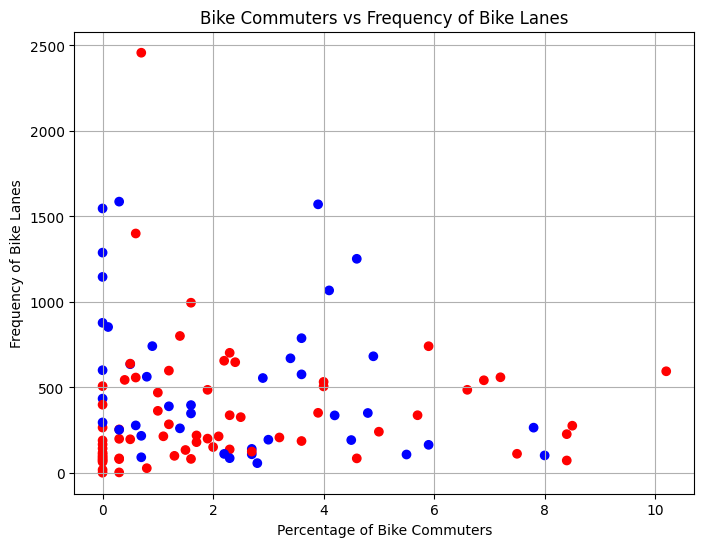

In [119]:
import matplotlib.pyplot as plt

bike_usage = [item[0] for item in frequency_trend]  # percentage of bike commuters
lane_freq = [item[1] for item in frequency_trend]  # freq of bike lanes
pop_density = [item[2] for item in frequency_trend] # population density
colors = ['blue' if i > mean_pop_density else 'red' for i in pop_density]

plt.figure(figsize=(8, 6))
plt.scatter(bike_usage, lane_freq, c=colors, marker='o')
# plt.ylim(0, 1750)
plt.xlabel('Percentage of Bike Commuters')
plt.ylabel('Frequency of Bike Lanes')
plt.title('Bike Commuters vs Frequency of Bike Lanes')
plt.grid(True)
plt.show()

The graph above shows a very scattered graph without much correlation at all. What we do see, though, is an abundance of census tracts with abolutely no bike usage -- this could be the effect of many outside causes. Maybe those tracts have few people/are not in residential areas, or the area is too far from metro areas to warant cycling, etc. As such, we can try to manually remove the 0 bike usage tracts (and hand remove one outlier) by only considering points with at least 0.3% cycling. This percentage was used after some trial and error in seeing which threshold would be reasonable to hit while finding the most observable trend. We can also fit lines of best fit determined by linear regression to these data points -- one for each level of population density.

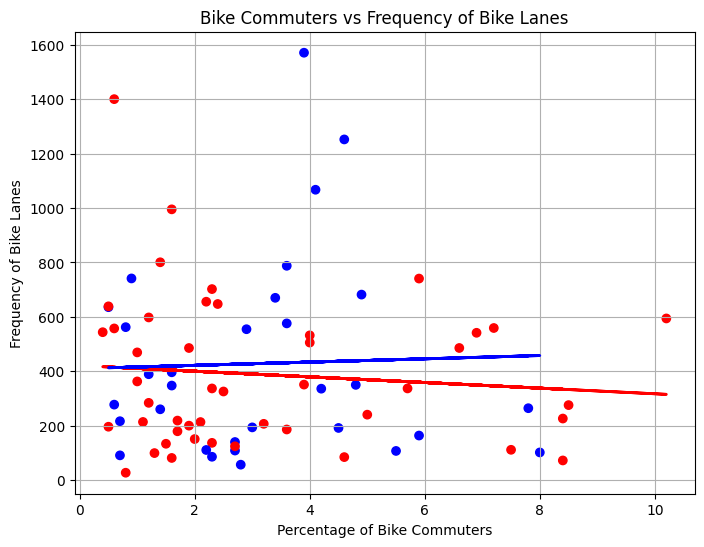

In [126]:
from sklearn.linear_model import LinearRegression

frequency_trend = [item for item in frequency_trend if item[0] > 0.3 and item[1] < 2300]
bike_usage = [item[0] for item in frequency_trend]  # percentage of bike commuters
lane_freq = [item[1] for item in frequency_trend]  # freq of bike lanes
pop_density = [item[2] for item in frequency_trend]
colors = ['blue' if i > mean_pop_density else 'red' for i in pop_density]

red_bike_usage = [bike_usage[i] for i in range(len(bike_usage)) if colors[i] == 'red']
red_lane_freq = [lane_freq[i] for i in range(len(lane_freq)) if colors[i] == 'red']
blue_bike_usage = [bike_usage[i] for i in range(len(bike_usage)) if colors[i] == 'blue']
blue_lane_freq = [lane_freq[i] for i in range(len(lane_freq)) if colors[i] == 'blue']

# linear regression
red_model = LinearRegression()
red_bike_usage = np.array(red_bike_usage).reshape(-1, 1)
red_model.fit(red_bike_usage, red_lane_freq)
blue_model = LinearRegression()
blue_bike_usage = np.array(blue_bike_usage).reshape(-1, 1)
blue_model.fit(blue_bike_usage, blue_lane_freq)

plt.figure(figsize=(8, 6))
plt.scatter(bike_usage, lane_freq, c=colors, marker='o')
plt.plot(red_bike_usage, red_model.predict(red_bike_usage), color='red', linewidth=2)
plt.plot(blue_bike_usage, blue_model.predict(blue_bike_usage), color='blue', linewidth=2)

# plt.ylim(0, 1750)
plt.xlabel('Percentage of Bike Commuters')
plt.ylabel('Frequency of Bike Lanes')
plt.title('Bike Commuters vs Frequency of Bike Lanes')
plt.grid(True)
plt.show()

However, even after pruning the tracts with very little to no bike usage, we are left with no trend. You could argue that the best fit lines could represent something, but even then anything they represent would be weak as the deviation of the points is far too high. As such, we have shown that **the percentage of bike commuters is not significantly affected by our metric of frequency** -- we suspect that other factors matter more than just pure frequency, such as proximity to metro areas, greenways, transit, or income level of the tract.

Now, we will also plot the data for bikelane connectivity, first starting with no filtering.

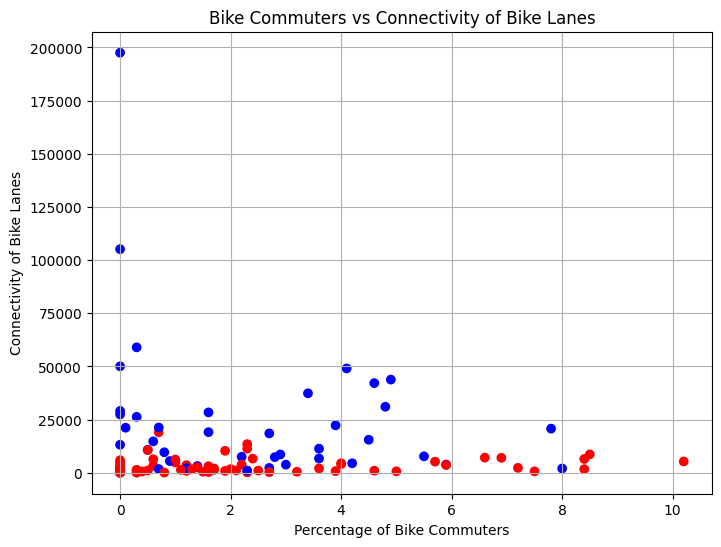

In [123]:
bike_usage = [item[0] for item in connectivity_trend]  # percentage of bike commuters
lane_connectivity = [item[1] for item in connectivity_trend]  # freq of bike lanes
pop_density = [item[2] for item in connectivity_trend]
colors = ['blue' if i > mean_pop_density else 'red' for i in pop_density]

plt.figure(figsize=(8, 6))
plt.scatter(bike_usage, lane_connectivity, marker='o', c=colors)
# plt.ylim(0, 50000)
plt.xlabel('Percentage of Bike Commuters')
plt.ylabel('Connectivity of Bike Lanes')
plt.title('Bike Commuters vs Connectivity of Bike Lanes')
plt.grid(True)
plt.show()

As we can see above, there are a few statistical outliers that significantly impact our observation of the data. Let's process this data by getting rid of the 0 bike usage tracts due to the reasons we said earlier.

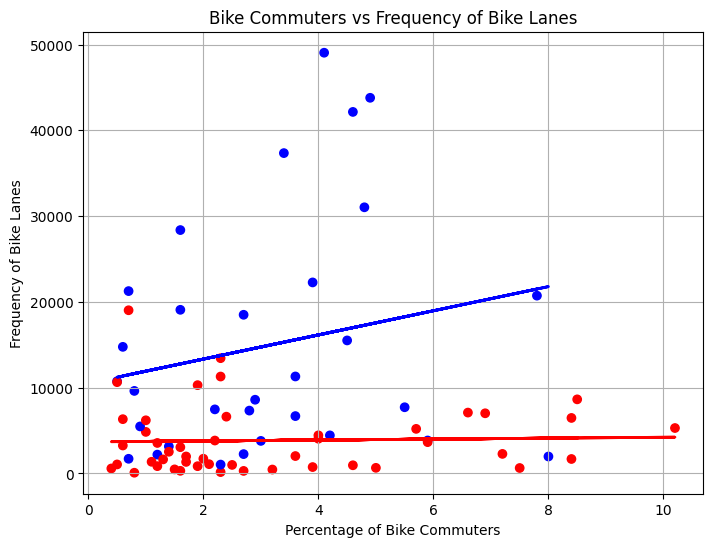

In [125]:
connectivity_trend = [item for item in connectivity_trend if item[0] > 0.3]
bike_usage = [item[0] for item in connectivity_trend]  # percentage of bike commuters
lane_connectivity = [item[1] for item in connectivity_trend]  # freq of bike lanes
pop_density = [item[2] for item in connectivity_trend]
colors = ['blue' if i > mean_pop_density else 'red' for i in pop_density]

red_bike_usage = [bike_usage[i] for i in range(len(bike_usage)) if colors[i] == 'red']
red_lane_freq = [lane_connectivity[i] for i in range(len(lane_connectivity)) if colors[i] == 'red']
blue_bike_usage = [bike_usage[i] for i in range(len(bike_usage)) if colors[i] == 'blue']
blue_lane_freq = [lane_connectivity[i] for i in range(len(lane_connectivity)) if colors[i] == 'blue']

# linear regression
red_model = LinearRegression()
red_bike_usage = np.array(red_bike_usage).reshape(-1, 1)
red_model.fit(red_bike_usage, red_lane_freq)
blue_model = LinearRegression()
blue_bike_usage = np.array(blue_bike_usage).reshape(-1, 1)
blue_model.fit(blue_bike_usage, blue_lane_freq)

plt.figure(figsize=(8, 6))
plt.scatter(bike_usage, lane_connectivity, c=colors, marker='o')
plt.plot(red_bike_usage, red_model.predict(red_bike_usage), color='red', linewidth=2)
plt.plot(blue_bike_usage, blue_model.predict(blue_bike_usage), color='blue', linewidth=2)

# plt.ylim(0, 50000)
plt.xlabel('Percentage of Bike Commuters')
plt.ylabel('Frequency of Bike Lanes')
plt.title('Bike Commuters vs Frequency of Bike Lanes')
plt.grid(True)
plt.show()

Now this is a more interesting graph. We can see a clear positive trend in highly dense census tracts, suggesting that **the connectivity of bike lanes to other bike lanes (and in general other areas) have a larger impact than frequency does in tracts of dense population.** This trend appears despite a number of outliers for high-density populations that show high cycling percentages despite low connectivity (which could maybe be the result of dense places having shorter cycling distances), and supports the notion that we should be implementing more *connective* bike lanes and being more mindful of their placement than simply implenting *more* of them.

Another interesting trend that comes up is how little connectivity impacts the low-density tracts. We suspect that this could be caused because of the following factors:
- Less dense tracts implies that they are more residential in nature / further from metro areas, and thus connectivity would not matter if the distance is too far for cycling
- Less dense tracts' cycling commuters would cycle regardless of connectivity of bike lanes (they are used to the more car-centric nature of these tracts)\

But we cannot overlook the majority of low-density tracts having low connectivity AND usage, which tracks with our preconceptions of less-dense areas. As these low-usage low-density tracts heavily outnumber the low-density tracts with high usage, there must be another factor barring the people from these tracts from biking -- after all, the frequency scatterplot shows that the tracts are not lacking in bikelane frequency. This could be something to look into for our extension project.

This marks the end of this particular branch of insight for Livable Streets Team C. Hopefully these observations are useful in deciding what to do next regarding bike lanes in Boston!